In [1]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

## STEP 1. Load Dataset

### 어린이,노인남녀,일반남녀 Mel_Spec 이미지로 구성


In [3]:
base = tf.io.gfile.glob(str('/home/tf2/VGG16/Dataset/train') + '/*/*')
base = tf.random.shuffle(base)
num_samples = len(base)
print('Number of total train examples:', num_samples)

Number of total train examples: 18002


## STEP 2. 전처리 (ImageDataGenerator)

In [7]:
train_dir = '/home/tf2/VGG16/Dataset/train'
test_dir = '/home/tf2/VGG16/Dataset/test'
valid_dir = '/home/tf2/VGG16/Dataset/validation'

In [8]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    )

### Training_generator / Validation_generator / Test_generator

In [9]:
training_generator = training_datagen.flow_from_directory(train_dir, 
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical',
                                                          subset='training',
                                                          classes=['kid','med','old']
                                                         )

Found 17999 images belonging to 3 classes.


In [10]:
validation_generator = training_datagen.flow_from_directory(valid_dir, 
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical',
                                                          classes=['kid','med','old']
                                                         )

Found 6000 images belonging to 3 classes.


In [11]:
test_generator = training_datagen.flow_from_directory(test_dir, 
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical',
                                                          classes=['kid','med','old']
                                                         )

Found 6000 images belonging to 3 classes.


## STEP 3. 모델 정의 (Sequential)

In [12]:
model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', kernel_initializer="he_normal" ,input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(), 
    Conv2D(32, (3, 3), activation='relu',kernel_initializer="he_normal"),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer="he_normal"),
    MaxPooling2D(2, 2), 
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer="he_normal"),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    # 2D -> 1D로 변환을 위하여 Flatten 합니다.
    Flatten(),
    # 과적합 방지를 위하여 Dropout을 적용합니다.z
    Dropout(0.5),
    # Dense
    Dense(512, activation='relu'),
    # Classification을 위한 Softmax 
    # 출력층의 갯수는 클래스의 갯수와 동일하게 맞춰줍니다 (3개), activation도 잊지마세요!
    Dense(3, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 111, 111, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 54, 54, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

## STEP 4. 컴파일 (compile)

In [14]:
!pip install keras

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [17]:
from tensorflow.keras import optimizers
tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['acc'])

## STEP 5. ModelCheckpoint

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [18]:
checkpoint_path = "sgd_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

## STEP 6. 학습 (fit)

In [19]:
epochs=20
history = model.fit(training_generator,
                    validation_data=(validation_generator),
                    epochs=epochs,
                    callbacks=[checkpoint]
                    )

Epoch 1/20
141/141 [==============================] - 445s 3s/step - loss: 0.8335 - acc: 0.6074 - val_loss: 0.7826 - val_acc: 0.6868

Epoch 00001: val_loss improved from inf to 0.78263, saving model to sgd_checkpoint.ckpt
Epoch 2/20
141/141 [==============================] - 435s 3s/step - loss: 0.5347 - acc: 0.6491 - val_loss: 0.7538 - val_acc: 0.5237

Epoch 00002: val_loss improved from 0.78263 to 0.75376, saving model to sgd_checkpoint.ckpt
Epoch 3/20
141/141 [==============================] - 436s 3s/step - loss: 0.5059 - acc: 0.6596 - val_loss: 0.5760 - val_acc: 0.5880

Epoch 00003: val_loss improved from 0.75376 to 0.57604, saving model to sgd_checkpoint.ckpt
Epoch 4/20
141/141 [==============================] - 403s 3s/step - loss: 0.4923 - acc: 0.6613 - val_loss: 0.7285 - val_acc: 0.5102

Epoch 00004: val_loss did not improve from 0.57604
Epoch 5/20
141/141 [==============================] - 405s 3s/step - loss: 0.4850 - acc: 0.6619 - val_loss: 1.2942 - val_acc: 0.5900

Epoch 0

## STEP 7. 학습 완료 후 Load Weights (ModelCheckpoint)

In [20]:
model.load_weights(checkpoint_path)

In [21]:
model.evaluate(validation_generator)

47/47 [==============================] - 86s 2s/step - loss: 0.5760 - acc: 0.5880


[0.5760390162467957, 0.5879999995231628]

In [22]:
model.evaluate(test_generator)

47/47 [==============================] - 89s 2s/step - loss: 1.7935 - acc: 0.4518


[1.7935353517532349, 0.4518333375453949]

In [23]:
import matplotlib.pyplot as plt

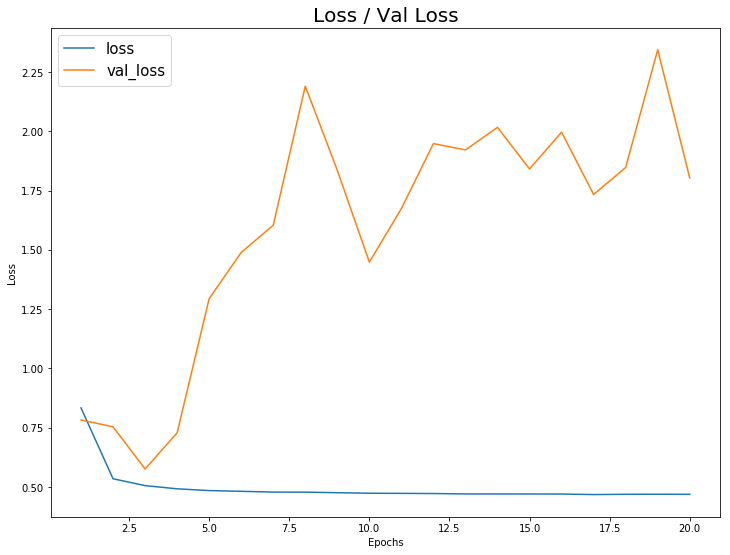

In [24]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

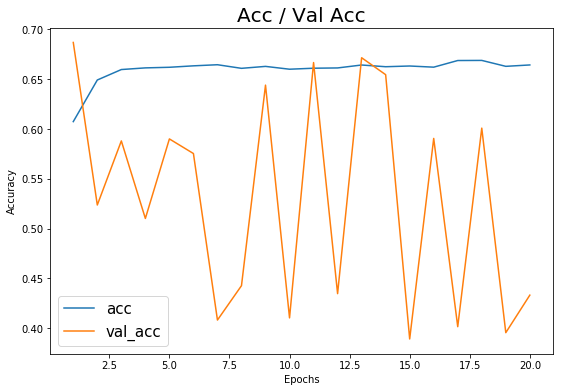

In [25]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(1, epochs+1), history.history['acc'])
plt.plot(np.arange(1, epochs+1), history.history['val_acc'])
plt.title('Acc / Val Acc', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['acc', 'val_acc'], fontsize=15)
plt.show()